# Using SVM Classifier for land cover mapping using sentinel 2
# Connect to your Google Drive 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setup Notebook - Install libraries geopandas, scikit-learn, treeinterpreter


In [2]:
# Requirements, will skip if already installed
%pip install geopandas rasterio rasterstats shapely
%pip install scikit-learn
%pip install treeinterpreter

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 19.3 MB 1.6 MB/s 
     |████████████████████████████████| 16.7 MB 21.8 MB/s 
     |████████████████████████████████| 6.3 MB 27.8 MB/s 
     |████████████████████████████████| 130 kB 45.9 MB/s 


In [3]:
from os import path as op
import pickle

import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

### Your root directory for outputs is set to your google drive

In [4]:
# your root directory for outputs is set to your google drive
# you should create a sub-folder called data under your 'Colab Notebooks'.
# An example is in https://developmentseed.org/sat-ml-training/GettingStarted#Explore-your-drive
my_root_dir = "/content/drive/MyDrive/svm"

## Label data preparation

We will be using an already prepared training dataset that consists of polygons of each land use classification. These polygons were prepared by people using GIS digitizing methods (QGIS, ArcGIS, JOSM) with satellite imagery to trace over.



In [5]:
# read in training data polygons that created as geojson from a shared directory
training_data = '/content/drive/MyDrive/svm/ground_truth.geojson'
training_vectors = gpd.read_file(training_data)

# make a bounding box and centroid for mapping
bbox = training_vectors.total_bounds
center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid

# show the 1st 5 lines
training_vectors.head()

,land_cover,geometry
0,mangrove,POINT (682524.554 2428865.934)
1,mangrove,POINT (699755.597 2451774.826)
2,mangrove,POINT (695651.305 2437261.119)
3,mangrove,POINT (678710.652 2420044.032)
4,mangrove,POINT (701099.667 2431146.900)


## Add Sentinel 2 Image


In [6]:
# Reference the raster on disk.
raster_file = '/content/drive/MyDrive/svm/s2_composite.tif'
print(raster_file)

/content/drive/MyDrive/svm/s2_composite.tif


## Model training

Now we're going to work on training a model to identify classes of land use based on the training data and the satellite imagery.

### Prepare Data

First we will need to do some preparation to organize the training data into the correct python types, and to extract sample pixels from the intersecting imagery.

In [7]:
# find all unique values of training data names to use as classes
classes = np.unique(training_vectors.land_cover)
classes

array(['agri', 'builtup', 'mangrove', 'shrub', 'water'], dtype=object)

In [8]:
# create a dictionary to convert class names into integers for modeling
class_dict = dict(zip(classes, range(len(classes))))
class_dict                  

{'agri': 0, 'builtup': 1, 'mangrove': 2, 'shrub': 3, 'water': 4}

This section loops through the training classes and their polygons reading the imagery raster extracting values.

In [9]:
raster_file = '/content/drive/MyDrive/svm/s2_composite.tif'


# a custom function for getting each value from the raster
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.land_cover, training_vectors.geometry):
        
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)
        
        # for each label pixel (places where the mask is true)
        label_pixels = np.argwhere(mask)
        
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])


In [10]:
# convert the training data lists into the appropriate numpy array shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((500, 10), (500,))

In addition to the raw pixel values we will calculated a couple of indices that help in some classifications.
* [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) - great for identiying photosynthesizing plants.
* [Normalized Difference Water Index (NDWI)](https://en.wikipedia.org/wiki/Normalized_difference_water_index) - great for identifying open water (when there isn't a lot of glare)

In [11]:
# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 3, 2)
ndwi = band_index(X, 1, 3)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape, y.shape

((500, 12), (500,))

Now were going to split 20% of the data to reserve for testing  the quality of the trained model.

In [12]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Since we don't have the same amount of training data for each class, we're going to calculate the relative quantities and tell the model so it can adjust to reduce bias.

In [13]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 0.013157894736842105,
 1: 0.011111111111111112,
 2: 0.013888888888888888,
 3: 0.013157894736842105,
 4: 0.011627906976744186}

#### Use Hypertuning to find the best parameters for training the model

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = { 'C':[0.1,1,100,500,1000],'kernel':['rbf'],'gamma': [1, 0.1, 0.0001,0.00000001,1.773792390407636e-07]}
grid = GridSearchCV(SVC(),param_grid)
grid.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 100, 500, 1000],
                         'gamma': [1, 0.1, 0.0001, 1e-08,
                                   1.773792390407636e-07],
                         'kernel': ['rbf']})

In [16]:
print(grid.best_params_)
print(grid.get_params)




{'C': 500, 'gamma': 1.773792390407636e-07, 'kernel': 'rbf'}
<bound method BaseEstimator.get_params of GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 100, 500, 1000],
                         'gamma': [1, 0.1, 0.0001, 1e-08,
                                   1.773792390407636e-07],
                         'kernel': ['rbf']})>


### Train SVM

In [17]:
# initialize a RandomForestClassifier
"""model = RandomForestClassifier(
    n_estimators=200,
    class_weight=class_weight_dict,
    max_depth=6,
    n_jobs=-1,
    verbose=1,
    random_state=0)"""

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

model = SVC(C=50, kernel='rbf')

# Fit Data
model.fit(X_train, y_train)

n_features = X_train.shape[1]
gamma = 1 / (n_features)

print(model._gamma)

# Predict labels for test data
svm_pred = model.predict(X_test)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_test, svm_pred)*100}")
print(classification_report(y_test, svm_pred))


1.773792390407636e-07
Accuracy: 80.0
              precision    recall  f1-score   support

           0       0.80      0.83      0.82        24
           1       0.50      0.70      0.58        10
           2       0.96      0.79      0.86        28
           3       0.79      0.79      0.79        24
           4       0.86      0.86      0.86        14

    accuracy                           0.80       100
   macro avg       0.78      0.79      0.78       100
weighted avg       0.82      0.80      0.81       100



# PLOT VARIABLE IMPORTANCE

In [18]:
# predict on X_test to evaluate the model
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=labels)

### Assess the Model

A confusion matrix shows a comparision between what the class is based on the test data, and what the model predicted it to be. Low numbers are good. The diagonal from top left to bottom right, is a class compared to itself should be high. Values range from 0 to 1.

In [19]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82        24
           1       0.50      0.70      0.58        10
           2       0.96      0.79      0.86        28
           3       0.79      0.79      0.79        24
           4       0.86      0.86      0.86        14

    accuracy                           0.80       100
   macro avg       0.78      0.79      0.78       100
weighted avg       0.82      0.80      0.81       100



In [20]:
print(confusion_matrix(y_test,preds))

[[20  4  0  0  0]
 [ 1  7  0  2  0]
 [ 1  1 22  2  2]
 [ 2  2  1 19  0]
 [ 1  0  0  1 12]]


In [21]:
print(accuracy_score(y_test, preds))

0.8


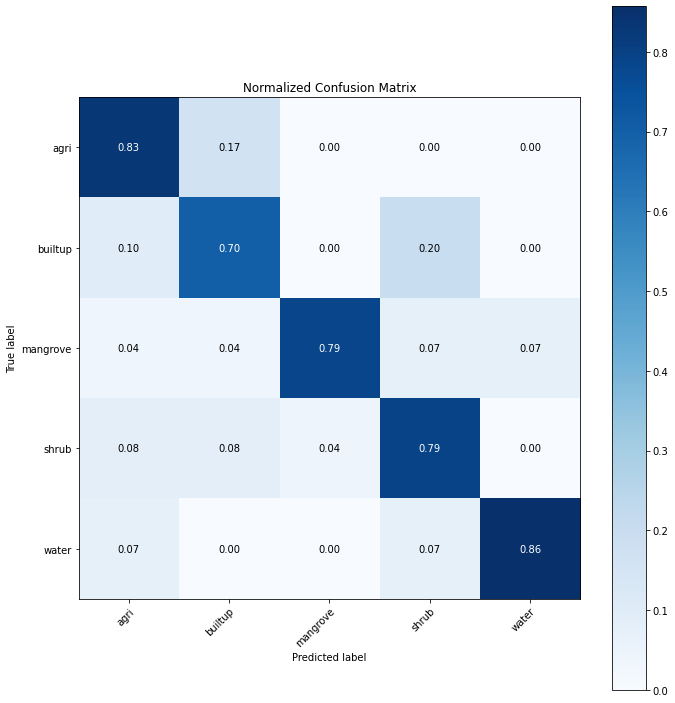

In [22]:
# plot the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

You can see the most often confused classes are shrub with builtup

## Using the Model

### Generate predictions over the full image

Now that we've trained and tested the model over the existing data we can use the trained SVM over a whole satellite image that covers a larger geospatial location. We can split the job into small tiles to optimize the compute power and potentially do the classification in parallel.

In [23]:
# in this case, we predict over the entire input image
# (only small portions were used for training)
new_image = raster_file

# specify the output
output_image = op.join(my_root_dir, "classification_0.tif")

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:

        # perform prediction on each small image patch to minimize required memory
        patch_size = 500

        for i in range((src.shape[0] // patch_size) + 1):
            for j in range((src.shape[1] // patch_size) + 1):
                # define the pixels to read (and write) with rasterio windows reading
                window = rasterio.windows.Window(
                    j * patch_size,
                    i * patch_size,
                    # don't read past the image bounds
                    min(patch_size, src.shape[1] - j * patch_size),
                    min(patch_size, src.shape[0] - i * patch_size))
                
                # read the image into the proper format
                data = src.read(window=window)
                
                # adding indices if necessary
                img_swp = np.moveaxis(data, 0, 2)
                img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                img_ndvi = band_index(img_flat, 3, 2)
                img_ndwi = band_index(img_flat, 1, 3)

                img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi], axis=1)

                # remove no data values, store the indices for later use
                m = np.ma.masked_invalid(img_w_ind)
                to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])

                # skip empty inputs
                if not len(to_predict):
                    continue
                # predict
                img_preds = model.predict(to_predict)

                # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
                # makes the assumption that all bands have identical no-data value arrangements
                output = np.zeros(img_flat.shape[0])
                output[~m.mask[:, 0]] = img_preds.flatten()
                # resize to the original image dimensions
                output = output.reshape(*img_swp.shape[:-1])

                # create our final mask
                mask = (~m.mask[:, 0]).reshape(*img_swp.shape[:-1])

                # write to the final files
                dst.write(output.astype(rasterio.uint8), 1, window=window)
                dst.write_mask(mask, window=window)

### Make a Map


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


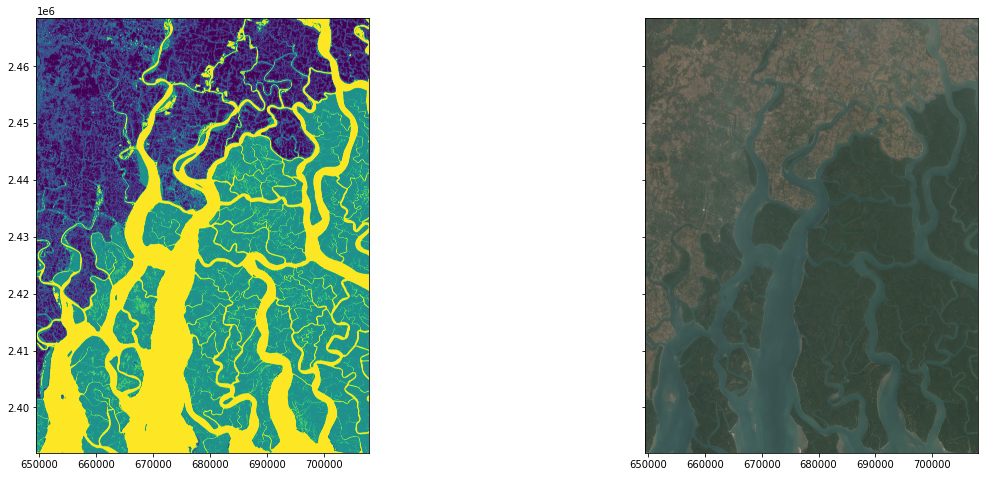

In [24]:
### Visualize the results
import matplotlib.pyplot as plt
from rasterio.plot import show
%matplotlib inline

# Load the original image
# Load the classification

output_image = '/content/drive/MyDrive/svm/classification_0.tif'

def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / np.float(imax - imin)
    return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  classes = class_raster.read()

# Compare side by side
with rasterio.open(raster_file, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([1,2,3])
  for band in range(s2.shape[0]):
    s2[band] = linear_rescale(
            s2[band], 
            in_range=(0, 3000), 
            out_range=[0, 255]
        )
  s2 = s2.astype(np.uint8)
  #print(s2.shape)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 8), sharey=True)
show(classes, transform=class_raster.transform, ax=ax1)
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2)
